# Assignment 3: Evaluating Classification Models

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

#  Deilverables and Definition
    1) Use three binary explanatory variables (default, housing, load). Predict subscription status (response) 

# A.  Library and data import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

import scikitplot as skplt
import matplotlib.pyplot as plt

from scipy import stats

imported_data = pd.read_csv('C:/Users/bblank/Documents/Northwestern MSDS/datasets/bank.csv', sep=';')
imported_data.dropna() 
display(imported_data.shape)
imported_data.describe()
display(imported_data.head())

#sets random seed for entire notebook
RANDOM_SEED = 42

#kfold for CV of models
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

(4521, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# B. EDA 
    1) We have a lot of categories, some are nested and within the nest some are valuable
    2) The data is really unbalanced, only 10% of the entries are postive for our target!

<AxesSubplot:xlabel='response', ylabel='count'>

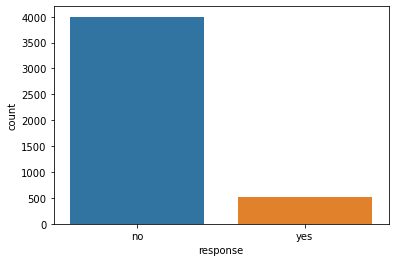

In [2]:
sns.countplot(imported_data.response)
#these are way unbalanced!

Text(0, 0.5, 'Proportion of Customers')

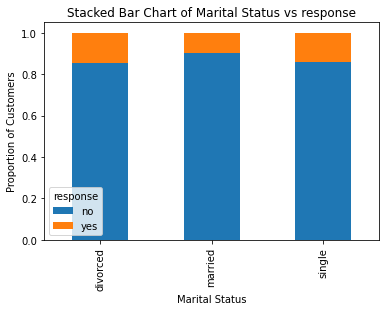

In [3]:
table=pd.crosstab(imported_data.marital,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs response')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')


Text(0, 0.5, 'Proportion of Customers')

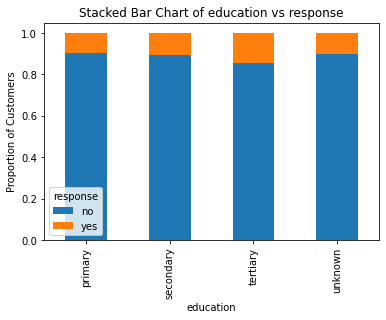

In [4]:
table=pd.crosstab(imported_data.education,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of education vs response')
plt.xlabel('education')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

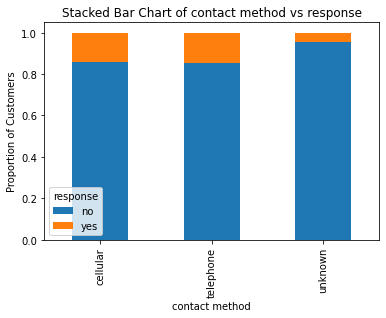

In [5]:
table=pd.crosstab(imported_data.contact,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of contact method vs response')
plt.xlabel('contact method')
plt.ylabel('Proportion of Customers')



Text(0, 0.5, 'Proportion of Customers')

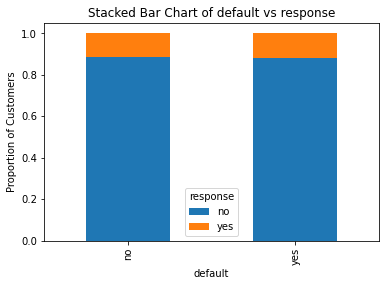

In [6]:
table=pd.crosstab(imported_data.default,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of default vs response')
plt.xlabel('default')
plt.ylabel('Proportion of Customers')

In [7]:
#convert columns from y/n to 1/9
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = imported_data['default'].map(convert_to_binary)
imported_data['default'] = default
# define binary variable for having a mortgage or housing loan
housing = imported_data['housing'].map(convert_to_binary)
imported_data['housing'] = housing
# define binary variable for having a personal loan
loan = imported_data['loan'].map(convert_to_binary)
imported_data['loan'] = loan
# define response variable to use in the model
response = imported_data['response'].map(convert_to_binary)
imported_data['response'] = response

display(imported_data.head())


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [8]:

df = imported_data.copy()
display(df.poutcome.value_counts())
display(df.contact.value_counts())
display(df.education.value_counts())
display(df.job.value_counts())
display(df.marital.value_counts())

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

In [9]:
#poutcome != response
df[df.poutcome == 'success'].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
49,61,admin.,married,unknown,0,4629,1,0,cellular,27,jan,181,1,92,1,success,1
70,37,management,married,tertiary,0,0,0,0,cellular,16,jul,268,2,182,3,success,1
98,36,blue-collar,divorced,secondary,0,2843,0,0,cellular,12,feb,473,1,182,1,success,0
110,21,student,single,secondary,0,2488,0,0,cellular,30,jun,258,6,169,3,success,1
156,55,admin.,married,secondary,0,602,0,0,cellular,1,jun,324,3,90,2,success,1


In [10]:
display(df.groupby(by='marital').agg(x= ('response', np.mean)))
display(df.groupby(by='contact').agg(x= ('response', np.mean)))
display(df.groupby(by='education').agg(x= ('response', np.mean)))
display(df.groupby(by='job').agg(x= ('response', np.mean)))

,x
marital,
divorced,0.145833
married,0.099035
single,0.139632


,x
contact,
cellular,0.143646
telephone,0.146179
unknown,0.046073


,x
education,
primary,0.094395
secondary,0.106245
tertiary,0.142963
unknown,0.101604


,x
job,
admin.,0.121339
blue-collar,0.072939
entrepreneur,0.089286
housemaid,0.125000
management,0.135191
retired,0.234783
self-employed,0.109290
services,0.091127
student,0.226190


In [11]:
#generates a binary response for married or not appends it to our dataframe
Married_Status = {'divorced' : 0, 'single' : 0, 'married' : 1}
married = df['marital'].map(Married_Status)
df['married'] = married

#generates a phonve vs unknown binary response and appends to dataframe
Contact_Method = {'telephone' : 1, 'cellular' : 1, 'unknown' : 0}
phone = df['contact'].map(Contact_Method)
df['phone'] = phone


Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'response', 'married', 'phone', 'retired', 'student'],
      dtype='object')

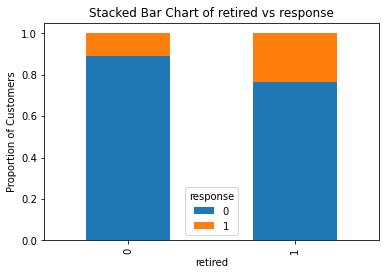

In [12]:
#generates a retried or not binary response column
df['retired'] = np.where(df['job'] == 'retired', 1 , 0)
table=pd.crosstab(df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')
#generates a student of not binary response column
df['student'] = np.where(df['job'] == 'student', 1 , 0)

#drops columns from above contact and marital now that we have a binary column for each
df.drop(['contact','marital'], axis=1, inplace=True)

df.columns

Text(0, 0.5, 'Proportion of Customers')

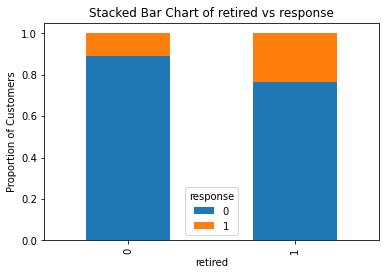

In [13]:
table=pd.crosstab(df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

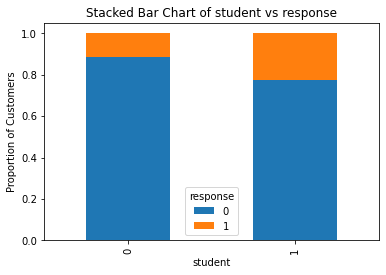

In [14]:
#there are a relatively small number of students <1% of the data. Likely should ignore this feature.
table=pd.crosstab(df.student,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of student vs response')
plt.xlabel('student')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

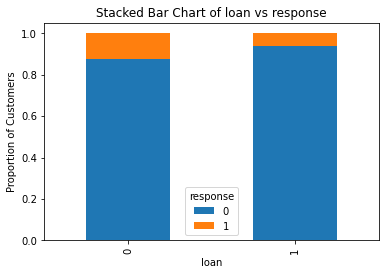

In [15]:
table=pd.crosstab(df.loan,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of loan vs response')
plt.xlabel('loan')
plt.ylabel('Proportion of Customers')

In [16]:
df.head()

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,married,phone,retired,student
0,30,unemployed,primary,0,1787,0,0,19,oct,79,1,-1,0,unknown,0,1,1,0,0
1,33,services,secondary,0,4789,1,1,11,may,220,1,339,4,failure,0,1,1,0,0
2,35,management,tertiary,0,1350,1,0,16,apr,185,1,330,1,failure,0,0,1,0,0
3,30,management,tertiary,0,1476,1,1,3,jun,199,4,-1,0,unknown,0,1,0,0,0
4,59,blue-collar,secondary,0,0,1,0,5,may,226,1,-1,0,unknown,0,1,0,0,0


In [17]:
bank_df = df[['default', 'housing', 'loan', 'response']].copy()

In [18]:
#returns the proportion of positve responses
display(bank_df.groupby(by = default).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = housing).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = loan).agg(x= ('response', np.mean)))

,x
default,
0,0.115186
1,0.118421


,x
housing,
0,0.153415
1,0.085971


,x
loan,
0,0.124804
1,0.062229


# C. Regression Comparisons
## C1. Logistic Regression Classifier (default, housing, loan; to describe response; bank_df)

In [19]:
#split our train test out making sure we don't enrich our sets with one particular response
D_Train, D_Test = train_test_split(bank_df, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
D_TrainY= D_Train['response'].copy()
D_TrainX= D_Train.drop('response', axis =1)

#Test X and y
D_TestY= D_Test['response'].copy()
D_TestX= D_Test.drop('response', axis =1)


## Evaluate if stratification

<AxesSubplot:xlabel='response', ylabel='count'>

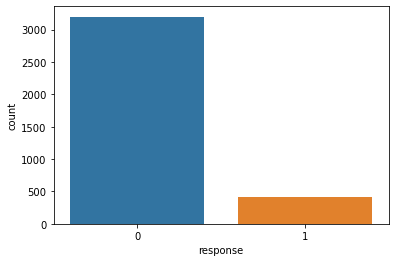

In [20]:
sns.countplot(D_Train.response)

<AxesSubplot:xlabel='response', ylabel='count'>

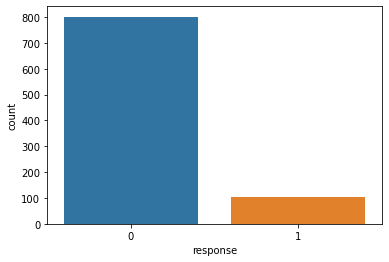

In [21]:
sns.countplot(D_Test.response)

In [22]:
D_TrainX.shape

(3616, 3)

### Pipeline construction
    1) I evaluated imputing the weights vs balanced weights, it looks like balanced might reverse the proportions
    2) AUC looks fairly good; 0.6; better than random chance!

In [23]:
#gets relative proportions of repsonses 
prop_1 = D_Train.response.sum()/D_Train.shape[0]
prop_0 = 1-prop_1

In [24]:
prop_1

0.115320796460177

In [25]:

Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = {0: prop_0, 1: prop_1}, random_state= RANDOM_SEED))])

#builds logistic regression pipeline
#Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = 'balanced', random_state= RANDOM_SEED))])
#fits logreg to out data
Logreg_pipe.fit(D_TrainX, D_TrainY)

#predict the labels from the train values
Logreg_train_pred = Logreg_pipe.predict_proba(D_TrainX)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression')

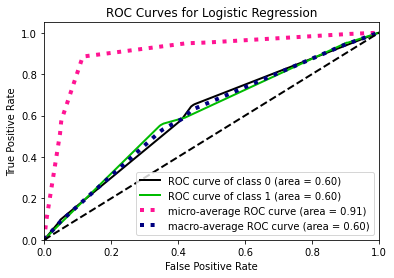

In [35]:

skplt.metrics.plot_roc_curve(D_TrainY, Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression')

### Cross Validation

In [27]:
cv_results = cross_val_score(Logreg_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.59228422 0.62827004 0.60070412 0.6109736  0.59459459 0.60271021
 0.53228102 0.66340951]


0.6031534140246049

## C2. Naive Bayes Classifier (default, housing, loan; to describe response; bank_df)

### Pipeline Construction

In [28]:
BernoulliNB_pipe = Pipeline([('regressor', BernoulliNB(alpha=0.8, class_prior=[prop_0, prop_1]))])
#fits logreg to out data
BernoulliNB_pipe.fit(D_TrainX, D_TrainY)

#predict the labels from the train values
BernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(D_TrainX)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier')

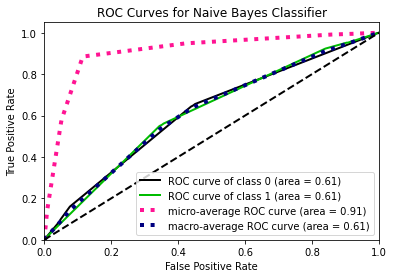

In [36]:
skplt.metrics.plot_roc_curve(D_TrainY, BernoulliNB_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier')

### Cross Validation

In [30]:
cv_results = cross_val_score(BernoulliNB_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.61327372 0.62827004 0.60070412 0.6144802  0.61818182 0.60271021
 0.54176909 0.66340951]


0.6103498396132581

# D. More features! (default, housing, loan, retired, married)


In [31]:
Expanded_bank= df[['default', 'housing', 'loan', 'retired', 'married', 'response']].copy()

In [32]:
E_Train, E_Test = train_test_split(Expanded_bank, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
E_TrainY= E_Train['response'].copy()
E_TrainX= E_Train.drop('response', axis =1)

#Test X and y
E_TestY= E_Test['response'].copy()
E_TestX= E_Test.drop('response', axis =1)



## D1. Logistic Regression

In [40]:
Logreg_pipe.fit(E_TrainX, E_TrainY)

#predict the labels from the train values
E_Logreg_train_pred = Logreg_pipe.predict_proba(E_TrainX)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression with additional features')

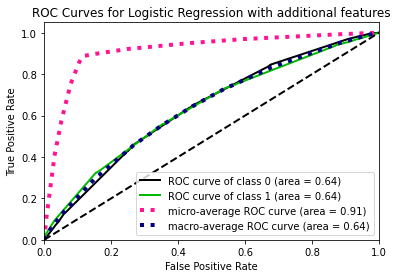

In [37]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression with additional features')

In [44]:
cv_results = cross_val_score(Logreg_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.63953737 0.6523873  0.63935749 0.60215553 0.63213213 0.62550338
 0.56902575 0.70767008]


0.633471128961313

## D2. Naive Bayes Classification

In [41]:
#fits logreg to out data
BernoulliNB_pipe.fit(E_TrainX, E_TrainY)

#predict the labels from the train values
EBernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(E_TrainX)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier with additional features')

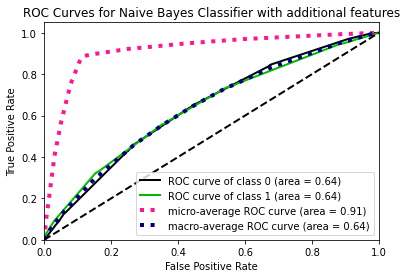

In [43]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier with additional features')

In [45]:
cv_results = cross_val_score(BernoulliNB_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.64606982 0.65256496 0.63642365 0.6058684  0.64348894 0.62550338
 0.56656747 0.70562122]


0.6352634810584441